# Ramp Optimization Examples

This notebook outlines an example to optimize the ramp settings for a few different types of observations.

In these types of optimizations, we must consider observations constraints such as saturation levels, SNR requirements, and limits on acquisition time.

**Note**: The reported acquisition time does not include obsevatory and instrument-level overheads, such as slew times, filter changes, script compilations, etc. It only includes detector readout times (including reset frames).

In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline

from IPython.display import display, Latex, clear_output

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S
from pynrc.pynrc_core import table_filter

pynrc.setup_logging('WARNING', verbose=False)

from astropy.table import Table

## Example 1: M-Dwarf companion (imaging vs coronagraphy)

We want to observe an M-Dwarf companion (K=18 mag) orbiting an F0V primary (K=13 mag) in the F430M filter. Assume the M-Dwarf flux is not significantly impacted by the primary's PSF (ie., in the background limited regime). In this scenario, the F0V star will saturate much more quickly compared to the fainter companion, so it limits which ramp settings we can use.

We will test a couple different types of observations (direct imaging vs coronagraphy).

In [4]:
# Get stellar spectra and normalize at K-Band
# The stellar_spectrum convenience function creates a Pysynphot spectrum
bp_k = S.ObsBandpass('k')
sp_M2V = pynrc.stellar_spectrum('M2V', 18, 'vegamag', bp_k)#, catname='ck04models')
sp_F0V = pynrc.stellar_spectrum('F0V', 13, 'vegamag', bp_k)#, catname='ck04models')

In [5]:
# Initiate a NIRCam observation
nrc = pynrc.NIRCam('F430M', wind_mode='WINDOW', xpix=160, ypix=160)

In [6]:
# Set some observing constraints
# Let's assume we want photometry on the primary to calibrate the M-Dwarf for direct imaging
#  - Set well_frac_max=0.75
# Want a SNR~100 in the F430M filter
#  - Set snr_goal=100
res = nrc.ramp_optimize(sp_M2V, sp_bright=sp_F0V, snr_goal=100, well_frac_max=0.75, verbose=True)

BRIGHT1
BRIGHT2
DEEP2
DEEP8
MEDIUM2
MEDIUM8
RAPID
SHALLOW2
SHALLOW4
 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
DEEP8         7    4     35.67    142.66    143.80    101.7    0.628    8.478
DEEP8         7    5     35.67    178.33    179.75    113.7    0.628    8.478
DEEP2         8    4     39.57    158.27    159.40    101.1    0.696    8.009
DEEP2         8    5     39.57    197.83    199.25    113.1    0.696    8.009
MEDIUM2      10    7     25.63    179.44    181.43    101.3    0.451    7.524
MEDIUM2      10    8     25.63    205.08    207.35    108.3    0.451    7.524
MEDIUM8       7    9     18.95    170.53    173.08     98.5    0.333    7.488
MEDIUM8       7   10     18.95    189.48    192.31    103.8    0.333    7.488
MEDIUM8       6   13     16.16    210.09    213.78    104.2    0.284    7.125
SHALLOW4     10   15     13.65    204.80    209.06     99.3    0.240    6.

In [7]:
# Print the Top 2 settings for each readout pattern
res2 = table_filter(res, 2)
print(res2)

 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
RAPID        10  501      2.79   1395.99   1538.17     99.9    0.049    2.547
RAPID        10  502      2.79   1398.77   1541.24    100.0    0.049    2.547
BRIGHT1      10  135      5.29    714.71    753.02     99.7    0.093    3.632
BRIGHT1      10  136      5.29    720.01    758.60    100.1    0.093    3.632
BRIGHT2      10   87      5.57    484.83    509.52     99.6    0.098    4.414
BRIGHT2      10   88      5.57    490.41    515.38    100.2    0.098    4.414
SHALLOW2     10   19     13.10    248.83    254.22    100.0    0.230    6.275
SHALLOW2     10   20     13.10    261.92    267.60    102.6    0.230    6.275
SHALLOW4     10   15     13.65    204.80    209.06     99.3    0.240    6.867
SHALLOW4     10   16     13.65    218.45    222.99    102.5    0.240    6.867
MEDIUM2      10    7     25.63    179.44    181.43    101.3    0

In [8]:
# Do the same thing, but for coronagraphic mask instead
#pynrc.setup_logging('DEBUG', verbose=False)
nrc = pynrc.NIRCam('F430M', mask='MASK430R', pupil='CIRCLYOT', 
                   wind_mode='WINDOW', xpix=320, ypix=320)

# We assume that longer ramps will give us the best SNR for time
patterns = ['MEDIUM8', 'DEEP8']
res = nrc.ramp_optimize(sp_M2V, sp_bright=sp_F0V, snr_goal=100, 
                        patterns=patterns, even_nints=True)

# Take the Top 2 settings for each readout pattern
res2 = table_filter(res, 2)
print(res2)

 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
MEDIUM8      10   84    104.77   8800.34   8891.81    100.4    0.001    1.065
MEDIUM8      10   86    104.77   9009.87   9103.52    101.6    0.001    1.065
DEEP8        20   12    414.79   4977.45   4990.52    102.5    0.003    1.451
DEEP8        19   12    393.41   4720.88   4733.95     99.3    0.003    1.442


#### RESULTS

Based on these two comparisons, it looks like direct imaging is much more efficient in getting to the requisite SNR. In addition, direct imaging gives us a photometric comparison source that is inaccessible with the coronagraph masks.

## Example 2: Exoplanet Coronagraphy

We want to observe GJ 504 for an hour in the F444W filter. 
 - What is the optimal ramp settings to maximize the SNR of GJ 504b?
 - What is the final background sensitivity limit?

In [9]:
# Get stellar spectra and normalize at K-Band
# The stellar_spectrum convenience function creates a Pysynphot spectrum
bp_k = pynrc.bp_2mass('ks')
sp_G0V = pynrc.stellar_spectrum('G0V', 4, 'vegamag', bp_k)

# Choose a representative planet spectrum
planet = pynrc.planets_sb12(atmo='hy3s', mass=8, age=200, entropy=8, distance=17.5)
sp_pl = planet.export_pysynphot()

# Renormalize to F360M = 18.8
bp_l = pynrc.read_filter('F360M') # 
sp_pl = sp_pl.renorm(18.8, 'vegamag', bp_l)

In [10]:
# Initiate a NIRCam observation
nrc = pynrc.NIRCam('F444W', pupil='CIRCLYOT', mask='MASK430R', wind_mode='WINDOW', xpix=320, ypix=320)

In [12]:
# Set even_nints=True assume 2 roll angles
res = nrc.ramp_optimize(sp_pl, sp_bright=sp_G0V, tacq_max=3600, tacq_frac=0.05, 
                        even_nints=True, verbose=True)

BRIGHT1
BRIGHT2
DEEP2
DEEP8
MEDIUM2
MEDIUM8
RAPID
SHALLOW2
SHALLOW4
 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
DEEP8         6   30    115.46   3463.69   3496.36    665.3    0.723   11.251
DEEP8         6   32    115.46   3694.60   3729.45    687.1    0.723   11.251
MEDIUM2      10   34     98.35   3343.96   3380.98    652.6    0.616   11.222
MEDIUM2      10   36     98.35   3540.66   3579.86    671.5    0.616   11.222
MEDIUM2      10   38     98.35   3737.36   3778.74    689.9    0.616   11.222
MEDIUM8      10   32    104.77   3352.51   3387.36    652.0    0.656   11.202
MEDIUM8      10   34    104.77   3562.04   3599.07    672.1    0.656   11.202
MEDIUM8      10   36    104.77   3771.57   3810.78    691.6    0.656   11.202
DEEP2         6   32    109.04   3489.35   3524.19    660.4    0.683   11.125
DEEP2         6   34    109.04   3707.43   3744.46    680.8    0.683   11.

In [13]:
# Take the Top 2 settings for each readout pattern
res2 = table_filter(res, 2)
print(res2)

 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
RAPID        10  304     10.69   3249.88   3580.93    371.1    0.067    6.200
RAPID        10  306     10.69   3271.26   3604.48    372.3    0.067    6.200
BRIGHT1      10  166     20.31   3371.75   3552.52    477.3    0.127    8.007
BRIGHT1      10  168     20.31   3412.38   3595.32    480.1    0.127    8.007
BRIGHT2      10  158     21.38   3378.17   3550.22    526.0    0.134    8.828
BRIGHT2      10  160     21.38   3420.93   3595.16    529.3    0.134    8.828
SHALLOW2     10   68     50.24   3416.65   3490.70    621.0    0.315   10.510
SHALLOW2     10   70     50.24   3517.14   3593.37    630.0    0.315   10.510
SHALLOW4     10   66     52.38   3457.28   3529.15    634.4    0.328   10.679
SHALLOW4     10   68     52.38   3562.04   3636.09    644.0    0.328   10.679
MEDIUM2      10   34     98.35   3343.96   3380.98    652.6    0

In [14]:
# The DEEP and MEDIUMs are very similar.
# Let's go with MEDIUM2 for more GROUPS & INTS 
# and slightly better efficiency over MEDIUM8
nrc.update_detectors(read_mode='MEDIUM2', ngroup=10, nint=36)

keys = list(nrc.multiaccum_times.keys())
keys.sort()
for k in keys:
    print("{:<10}: {: 12.5f}".format(k, nrc.multiaccum_times[k]))

t_acq     :   3579.86304
t_exp     :   3540.66048
t_frame   :      1.06904
t_group   :     10.69040
t_int     :     98.35168
t_int_tot :     99.44064


In [15]:
# Background sensitivity (5 sigma)
sens_dict = nrc.sensitivity(nsig=5, units='vegamag', verbose=True)

Point Source Sensitivity (5-sigma): 21.75 vegamag
Surface Brightness Sensitivity (5-sigma): 23.01 vegamag/arcsec^2


## Example 3: Single-Object Grism Spectroscopy

Similar to the above, but instead we want to obtain a slitless grism spectrum of a K=12 mag M9V dwarf. Each grism resolution element should have SNR~100.

In [16]:
# M9V star at K=12 mags
bp_k = S.ObsBandpass('k')
sp_M9V = pynrc.stellar_spectrum('M9V', 12, 'vegamag', bp_k)

In [17]:
nrc = pynrc.NIRCam('F444W', pupil='GRISM0', wind_mode='STRIPE', ypix=64)

In [19]:
# Set a minimum of 10 integrations to be robust against cosmic rays
# Also set a minimum of 10 groups for good ramp sampling
res = nrc.ramp_optimize(sp_M9V, snr_goal=100, nint_min=10, ng_min=10, verbose=True)

BRIGHT1
BRIGHT2
DEEP2
DEEP8
MEDIUM2
MEDIUM8
RAPID
SHALLOW2
SHALLOW4
 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
DEEP8        10   10     64.03    640.35    643.81    249.0    0.041    9.814
DEEP2        10   10     61.99    619.91    623.37    244.2    0.040    9.779
MEDIUM8      10   10     33.38    333.80    337.26    173.2    0.021    9.433
MEDIUM2      10   10     31.34    313.36    316.82    166.9    0.020    9.375
SHALLOW4     10   10     16.69    166.90    170.36    115.7    0.011    8.867
SHALLOW2     10   10     16.01    160.09    163.55    110.7    0.010    8.654
BRIGHT2      10   27      6.81    183.93    193.27     98.5    0.004    7.082
BRIGHT2      10   28      6.81    190.74    200.43    100.3    0.004    7.082
BRIGHT2      10   29      6.81    197.55    207.59    102.0    0.004    7.082
BRIGHT1      10   36      6.47    232.98    245.43     98.9    0.004    6.

In [20]:
# Print the Top 2 settings for each readout pattern
res2 = table_filter(res, 2)
print(res2)

 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
RAPID        10  116      3.41    395.11    435.23     99.9    0.002    4.786
RAPID        10  117      3.41    398.51    438.98    100.3    0.002    4.786
BRIGHT1      10   36      6.47    232.98    245.43     98.9    0.004    6.313
BRIGHT1      10   37      6.47    239.45    252.25    100.3    0.004    6.313
BRIGHT2      10   27      6.81    183.93    193.27     98.5    0.004    7.082
BRIGHT2      10   28      6.81    190.74    200.43    100.3    0.004    7.082
SHALLOW2     10   10     16.01    160.09    163.55    110.7    0.010    8.654
SHALLOW4     10   10     16.69    166.90    170.36    115.7    0.011    8.867
MEDIUM2      10   10     31.34    313.36    316.82    166.9    0.020    9.375
MEDIUM8      10   10     33.38    333.80    337.26    173.2    0.021    9.433
DEEP2        10   10     61.99    619.91    623.37    244.2    0

In [21]:
# Let's say we choose SHALLOW4, NGRP=10, NINT=10
# Update detector readout
nrc.update_detectors(read_mode='SHALLOW4', ngroup=10, nint=10)

keys = list(nrc.multiaccum_times.keys())
keys.sort()
for k in keys:
    print("{:<10}: {: 12.5f}".format(k, nrc.multiaccum_times[k]))

t_acq     :    170.36264
t_exp     :    166.89890
t_frame   :      0.34061
t_group   :      1.70305
t_int     :     16.68989
t_int_tot :     17.03574


In [22]:
# Print final wavelength-dependent SNR
# For spectroscopy, the snr_goal is the median over the bandpass
snr_dict = nrc.sensitivity(sp=sp_M9V, forwardSNR=True, units='mJy', verbose=True)

F444W SNR for M9V source
   Wave      SNR    Flux (mJy)
--------- --------- ----------
     3.80      6.03       5.01
     3.90    166.73       4.85
     4.00    177.67       4.62
     4.10    169.44       4.40
     4.20    159.50       4.17
     4.30    143.53       3.70
     4.40    132.39       3.57
     4.50    120.80       3.20
     4.60    110.68       3.16
     4.70     99.12       2.98
     4.80     92.55       3.03
     4.90     80.37       2.92
     5.00     38.29       2.67
     5.10      0.75       2.76


**Mock observed spectrum**

Create a series of ramp integrations based on the current NIRCam settings. The gen_exposures() function creates a series of mock observations in raw DMS format by default. By default, it's point source objects centered in the observing window.

In [23]:
# Ideal spectrum and wavelength solution
wspec, imspec = nrc.gen_psf(sp=sp_M9V)

# Resize to detector window
nx = nrc.det_info['xpix']
ny = nrc.det_info['ypix']

In [24]:
# Create a series of ramp integrations based on the current NIRCam settings
# Output is 10 HDULists
im_slope = imspec + nrc.bg_zodi()
res = nrc.gen_exposures(im_slope=im_slope, return_results=True, targ_name='sp_M9V')

In [25]:
header = res[0]['PRIMARY'].header
tvals = (np.arange(header['NGROUPS'])+1) * header['TGROUP']
slope_list = []

for hdul in res:
    header = hdul['PRIMARY'].header
    data = hdul['SCI'].data
    ref = pynrc.ref_pixels.NRC_refs(data, header, DMS=True, do_all=False)
    ref.calc_avg_amps()
    ref.correct_amp_refs()

    # Linear fit to determine slope image
    cf = nrc_utils.jl_poly_fit(tvals, ref.data, deg=1)
    slope_list.append(cf[1])
    
# Create a master averaged slope image
slopes_all = np.array(slope_list)
slope_sim = slopes_all.mean(axis=0) * nrc.Detectors[0].gain

In [26]:
# Expand wspec to nx (fill value of 0)
# Then shrink to a size excluding wspec=0
# This assumes simulated spectrum is centered
wspec = nrc_utils.pad_or_cut_to_size(wspec, nx)
ind = wspec>0

# Estimate background emission and subtract from slope_sim
bg = np.median(slope_sim[:,~ind])
slope_sim = slope_sim[:,ind] - bg
wspec = wspec[ind]

In [27]:
# Extract 2 spectral x 5 spatial pixels

# First, cut out the central 5 pixels
slope_sub = nrc_utils.pad_or_cut_to_size(slope_sim, (5,slope_sim.shape[1]))
slope_sub_ideal = nrc_utils.pad_or_cut_to_size(imspec, (5,imspec.shape[1]))

# Sum along the spatial axis
spec = slope_sub.sum(axis=0)
spec_ideal = slope_sub_ideal.sum(axis=0)
spec_ideal_rebin = nrc_utils.frebin(spec_ideal, scale=0.5, total=False)

# Build a quick RSRF from extracted ideal spectral slope
sp_M9V.convert('mjy')
rsrf = spec_ideal / sp_M9V.sample(wspec*1e4)

# Rebin along spectral direction
wspec_rebin = nrc_utils.frebin(wspec, scale=0.5, total=False)
spec_rebin_cal = nrc_utils.frebin(spec/rsrf, scale=0.5, total=False)

In [28]:
# Expected noise per extraction element
snr_interp = np.interp(wspec_rebin, snr_dict['wave'], snr_dict['snr'])
_spec_rebin = spec_ideal_rebin / snr_interp
_spec_rebin_cal = _spec_rebin / nrc_utils.frebin(rsrf, scale=0.5, total=False)

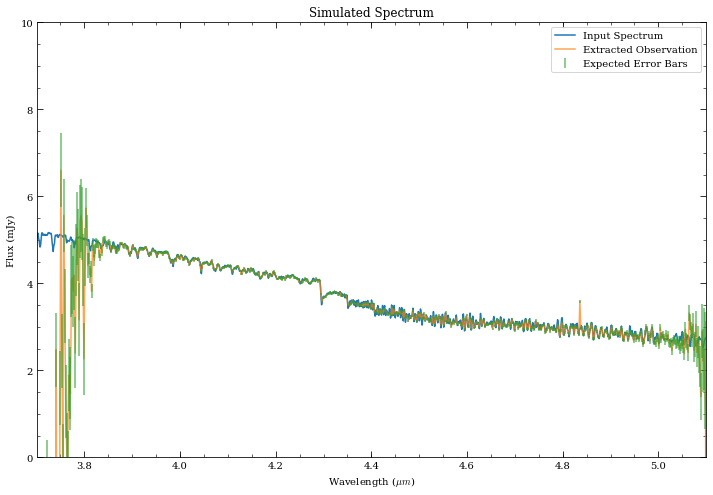

In [29]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.plot(sp_M9V.wave/1e4, sp_M9V.flux, label='Input Spectrum')
ax.plot(wspec_rebin, spec_rebin_cal, alpha=0.7, label='Extracted Observation')
ax.errorbar(wspec_rebin, spec_rebin_cal, yerr=_spec_rebin_cal, zorder=3,
            fmt='none', label='Expected Error Bars', alpha=0.7)

ax.set_ylim([0,10])
ax.set_xlim([3.7,5.1])

ax.set_xlabel('Wavelength ($\mu m$)')
ax.set_ylabel('Flux (mJy)')
ax.set_title('Simulated Spectrum')

ax.legend(loc='upper right');

## Example 4: Exoplanet Transit Spectroscopy

Let's say we want to observe an exoplanet transit using NIRCam grisms in the F322W2 filter. 

We assume a 2.1-hour transit duration for a K6V star (K=8.4 mag).

In [30]:
nrc = pynrc.NIRCam('F322W2', pupil='GRISM0', wind_mode='STRIPE', ypix=64)

In [31]:
# K6V star at K=8.4 mags
bp_k = S.ObsBandpass('k')
sp_K6V = pynrc.stellar_spectrum('K6V', 8.4, 'vegamag', bp_k)

In [32]:
# Constraints
well     = 0.5        # Keep well below 50% full
tacq     = 2.1*3600.  # 2.1 hour transit duration
ng_max   = 30         # Transit spectroscopy allows for up to 30 groups per integrations
nint_max = int(1e6)   # Effectively no limit on number of integrations

# Let's bin the spectrum to R~100
# dw_bin is a passable parameter for specifiying spectral bin sizes
R = 100
dw_bin = (nrc.bandpass.avgwave() / 10000) / R

In [35]:
res = nrc.ramp_optimize(sp_K6V, tacq_max=tacq, nint_max=nint_max, 
                        ng_min=10, ng_max=ng_max, well_frac_max=well, 
                        dw_bin=dw_bin, verbose=True)

BRIGHT1
BRIGHT2
DEEP2
DEEP8
MEDIUM2
MEDIUM8
RAPID
SHALLOW2
SHALLOW4
 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
BRIGHT1      25  442     16.69   7376.93   7529.80  30176.2    0.498  347.754
BRIGHT1      25  443     16.69   7393.62   7546.84  30210.3    0.498  347.754
BRIGHT1      25  444     16.69   7410.31   7563.87  30244.4    0.498  347.754
BRIGHT1      25  445     16.69   7427.00   7580.91  30278.5    0.498  347.754
BRIGHT1      25  446     16.69   7443.69   7597.95  30312.5    0.498  347.754
BRIGHT1      24  460     16.01   7363.99   7523.08  30132.7    0.478  347.408
BRIGHT2      24  451     16.35   7373.53   7529.51  29860.3    0.488  344.121
BRIGHT2      24  452     16.35   7389.87   7546.20  29893.4    0.488  344.121
BRIGHT2      24  453     16.35   7406.22   7562.90  29926.5    0.488  344.121
BRIGHT2      24  454     16.35   7422.57   7579.59  29959.5    0.488  344.

In [36]:
# Print the Top 2 settings for each readout pattern
res2 = table_filter(res, 2)
print(res2)

 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
RAPID        30  713     10.22   7285.65   7532.24  29770.9    0.305  343.028
RAPID        30  714     10.22   7295.87   7542.81  29791.8    0.305  343.028
BRIGHT1      25  442     16.69   7376.93   7529.80  30176.2    0.498  347.754
BRIGHT1      25  443     16.69   7393.62   7546.84  30210.3    0.498  347.754
BRIGHT2      24  451     16.35   7373.53   7529.51  29860.3    0.488  344.121
BRIGHT2      24  452     16.35   7389.87   7546.20  29893.4    0.488  344.121
SHALLOW2     10  460     16.01   7363.99   7523.08  29797.7    0.478  343.545
SHALLOW2     10  461     16.01   7380.00   7539.44  29830.1    0.478  343.545
SHALLOW4     10  442     16.69   7376.93   7529.80  29235.0    0.498  336.907
SHALLOW4     10  443     16.69   7393.62   7546.84  29268.0    0.498  336.907


In [37]:
# Even though BRIGHT1 has a slight efficiency preference over RAPID 
# and BRIGHT2, we decide to choose RAPID, because we are convinced 
# that saving all data (and no coadding) is a better option. 
# If APT informs you that the data rates or total data shorage is 
# an issue, you can select one of the other options.

# Update to RAPID, ngroup=30, nint=715 and plot PPM
nrc.update_detectors(read_mode='RAPID', ngroup=30, nint=715)
snr_dict = nrc.sensitivity(sp=sp_K6V, dw_bin=dw_bin, forwardSNR=True, units='Jy')
wave = np.array(snr_dict['wave'])
snr  = np.array(snr_dict['snr'])

# Let assume bg subtraction of something with similar noise
snr /= np.sqrt(2.)
ppm = 1e6 / snr

# NOTE: We have up until now neglected to include a "noise floor"
# which represents the expected minimum achievable ppm from
# unknown systematics. To first order, this can be added in 
# quadrature to the calculated PPM.
noise_floor = 30 # in ppm
ppm_floor = np.sqrt(ppm**2 + noise_floor**2)

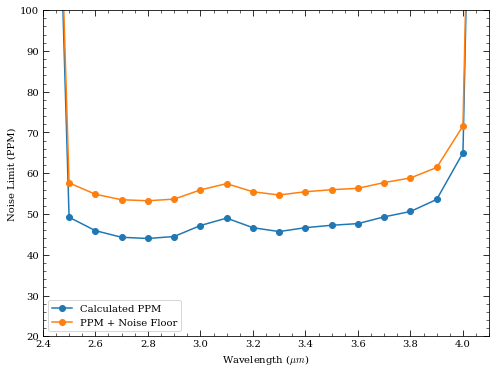

In [38]:
plt.plot(wave, ppm, marker='o', label='Calculated PPM')
plt.plot(wave, ppm_floor, marker='o', label='PPM + Noise Floor')
plt.xlabel('Wavelength ($\mu m$)')
plt.ylabel('Noise Limit (PPM)')
plt.xlim([2.4,4.1])
plt.ylim([20,100])
plt.legend()

## Example 5: Extended Souce

Expect some faint galaxies of 25 ABMag/arcsec^2 in our field. What is the best we can do with 10,000 seconds of acquisition time? 

In [39]:
# Detection bandpass is F200W
nrc = pynrc.NIRCam('F200W')

# Flat spectrum (in photlam) with ABMag = 25 in the NIRCam bandpass
sp = pynrc.stellar_spectrum('flat', 25, 'abmag', nrc.bandpass)

In [40]:
res = nrc.ramp_optimize(sp, is_extended=True, tacq_max=10000, tacq_frac=0.05, verbose=True)

BRIGHT1
BRIGHT2
DEEP2
DEEP8
MEDIUM2
MEDIUM8
RAPID
SHALLOW2
SHALLOW4
 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
MEDIUM8      10    8   1052.20   8417.63   8503.53      9.8    0.000    0.106
MEDIUM8       9    9    944.84   8503.52   8600.16      9.8    0.000    0.106
MEDIUM8       9   10    944.84   9448.36   9555.73     10.4    0.000    0.106
MEDIUM8      10    9   1052.20   9469.83   9566.47     10.4    0.000    0.106
MEDIUM8       9   11    944.84  10393.19  10511.30     10.9    0.000    0.106
MEDIUM8      10   10   1052.20  10522.03  10629.41     11.0    0.000    0.106
DEEP8         8    5   1589.04   7945.21   7998.90      9.4    0.000    0.105
DEEP8         7    6   1374.31   8245.84   8310.27      9.6    0.000    0.105
MEDIUM8       8   11    837.47   9212.15   9330.26     10.2    0.000    0.105
DEEP8         6    8   1159.57   9276.57   9362.47     10.2    0.000    0.

In [41]:
# Print the Top 2 settings for each readout pattern
res2 = table_filter(res, 2)
print(res2)

 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
RAPID        10   83    107.37   8911.52   9802.68      4.7    0.000    0.046
RAPID        10   84    107.37   9018.89   9920.78      4.7    0.000    0.046
BRIGHT1      10   45    204.00   9179.94   9663.10      6.3    0.000    0.063
BRIGHT1      10   46    204.00   9383.94   9877.83      6.4    0.000    0.063
BRIGHT2      10   43    214.74   9233.62   9695.31      7.5    0.000    0.076
BRIGHT2      10   44    214.74   9448.36   9920.78      7.6    0.000    0.076
SHALLOW2     10   18    504.63   9083.31   9276.57      9.2    0.000    0.095
SHALLOW2     10   19    504.63   9587.94   9791.94      9.5    0.000    0.095
SHALLOW4     10   17    526.10   8943.73   9126.26      9.7    0.000    0.101
SHALLOW4     10   18    526.10   9469.83   9663.10     10.0    0.000    0.101
MEDIUM2      10    9    987.78   8890.05   8986.68      9.8    0

In [42]:
# MEDIUM8 10 10 looks like a good option
nrc.update_detectors(read_mode='MEDIUM8', ngroup=10, nint=10, verbose=True)

New Ramp Settings:
  read_mode :  MEDIUM8
  nf        :        8
  nd2       :        2
  ngroup    :       10
  nint      :       10
New Detector Settings
  wind_mode :     FULL
  xpix      :     2048
  ypix      :     2048
  x0        :        0
  y0        :        0
New Ramp Times
  t_group   :  107.368
  t_frame   :   10.737
  t_int     : 1052.203
  t_int_tot : 1062.940
  t_exp     : 10522.035
  t_acq     : 10629.408


In [43]:
# Calculate flux/mag for various nsigma detection limits
tbl = Table(names=('Sigma', 'Point (nJy)',    'Extended (nJy/asec^2)', 
                            'Point (AB Mag)', 'Extended (AB Mag/asec^2)'))
tbl['Sigma'].format = '.0f'
for k in tbl.keys()[1:]:
    tbl[k].format = '.2f'

for sig in [1,3,5,10]:
    snr_dict1 = nrc.sensitivity(nsig=sig, units='nJy', verbose=False)
    snr_dict2 = nrc.sensitivity(nsig=sig, units='abmag', verbose=False)
    tbl.add_row([sig, snr_dict1[0]['sensitivity'], snr_dict1[1]['sensitivity'],
                snr_dict2[0]['sensitivity'], snr_dict2[1]['sensitivity']])

In [44]:
tbl

Sigma,Point (nJy),Extended (nJy/asec^2),Point (AB Mag),Extended (AB Mag/asec^2)
float64,float64,float64,float64,float64
1,1.17,32.31,31.23,27.63
3,3.52,97.36,30.03,26.43
5,5.89,163.00,29.47,25.87
10,11.89,329.71,28.71,25.10
